 # 1.0 Introduction

Homeless animals cause a major social threat, and many charitable organizations are working to reduce these social problems and to help these animals to find adoption homes. This project utilizes the “Predict Pet Adoption Status” dataset from Kaggle to train a machine learning model to predict the likelihood of a homeless animal being adopted. By analyzing the animal's breed, age, health condition and other factors, it helps adoption agencies more accurately assess which animals are more likely to be adopted, thus helping these charities optimize their resource allocation and increase the adoption success rate.

## 2.0 Data Loading and Exploration

### 2.1 Import Libraries

In [2]:
# Data manipulation and preprocessing
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data balancing
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

# Machine learning models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Deep learning models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameter optimization
import keras_tuner as kt


2025-03-04 18:08:46.116429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741111726.143876     114 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741111726.154691     114 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 18:08:46.188482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2.2 Data Loading

In [3]:
# Define the file path
file_path = 'dataset/pet_adoption_data.csv'

# Read the data
pad = pd.read_csv(file_path)

### 2.3 Data exploring

Briefly browse the dataset to explore available columns and their patterns.

In [4]:
pad.head()

,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood
0,500,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0
1,501,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0
2,502,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0
3,503,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0
4,504,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0


In [5]:
pad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PetID               2007 non-null   int64  
 1   PetType             2007 non-null   object 
 2   Breed               2007 non-null   object 
 3   AgeMonths           2007 non-null   int64  
 4   Color               2007 non-null   object 
 5   Size                2007 non-null   object 
 6   WeightKg            2007 non-null   float64
 7   Vaccinated          2007 non-null   int64  
 8   HealthCondition     2007 non-null   int64  
 9   TimeInShelterDays   2007 non-null   int64  
 10  AdoptionFee         2007 non-null   int64  
 11  PreviousOwner       2007 non-null   int64  
 12  AdoptionLikelihood  2007 non-null   int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 204.0+ KB


Understanding the basic statistics about features.

In [6]:
column_choose=['AgeMonths','WeightKg','TimeInShelterDays']
desc = pad[column_choose]

# Print the descriptive statistics
desc.describe()

,AgeMonths,WeightKg,TimeInShelterDays
count,2007.000000,2007.000000,2007.000000
mean,92.279522,15.705776,43.974091
std,52.148363,8.327749,25.740253
min,1.000000,1.018198,1.000000
25%,48.000000,8.730396,21.000000
50%,94.000000,15.925416,45.000000
75%,138.000000,22.737180,66.000000
max,179.000000,29.995628,89.000000


Exploring the columns that needs encoding to see if reducing dimensions is needed.

In [7]:
pad.groupby("PetType").agg(Count = ('AdoptionLikelihood', 'count')).reset_index().sort_values(by = 'Count', ascending = False)

,PetType,Count
2,Dog,522
1,Cat,505
3,Rabbit,493
0,Bird,487


In [8]:
pad.groupby("Breed").agg(Count = ('AdoptionLikelihood', 'count')).reset_index().sort_values(by = 'Count', ascending = False)

,Breed,Count
5,Rabbit,493
2,Parakeet,487
6,Siamese,253
3,Persian,252
1,Labrador,193
4,Poodle,167
0,Golden Retriever,162


In [9]:
pad.groupby("Color").agg(Count = ('AdoptionLikelihood', 'count')).reset_index().sort_values(by = 'Count', ascending = False)

,Color,Count
4,White,420
3,Orange,409
2,Gray,400
0,Black,395
1,Brown,383


In [10]:
pad.groupby("Size").agg(Count = ('AdoptionLikelihood', 'count')).reset_index().sort_values(by = 'Count', ascending = False)

,Size,Count
1,Medium,714
2,Small,663
0,Large,630


It looks like that there are enough columes for data analysing. As there are more than 10 pets in each colume, I decided not to do dimensionality reduction. 

# 3.0 Data Cleaning

### 3.1 Preprocessing

Check for null and repeated values and remove outliers.

In [11]:
print(pad.isnull().sum())

PetID                 0
PetType               0
Breed                 0
AgeMonths             0
Color                 0
Size                  0
WeightKg              0
Vaccinated            0
HealthCondition       0
TimeInShelterDays     0
AdoptionFee           0
PreviousOwner         0
AdoptionLikelihood    0
dtype: int64


There's no missing values in the dataset.

In [12]:
duplicates = int(pad.duplicated().sum())

duplicates

0

There's no repeated rows.

The outliers are excluded based on the IQR Interquartile Range, to prevent the extreme values from skewing statistical analyses and machine learning predictions.

In [13]:
# Select the columns to clean
cols_to_clean = ['AgeMonths', 'WeightKg', 'TimeInShelterDays']

# Compute the first quartile (Q1) and third quartile (Q3)
Q1 = pad[cols_to_clean].quantile(0.25)  # 25th percentile
Q3 = pad[cols_to_clean].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile range

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where any of the selected columns contain outliers
pad_cleaned = pad[~((pad[cols_to_clean] < lower_bound) | (pad[cols_to_clean] > upper_bound)).any(axis=1)]

# Overwrite the original dataset
pad = pad_cleaned.reset_index(drop=True)

### 3.2 Encoding Categorical Variables (One-Hot Encoding)

In [14]:
# Define categorical features
categorical_features = ["PetType", "Breed", "Color", "Size"]

# Initialize One-Hot Encoder with correct parameters
encoder = OneHotEncoder(sparse_output=False, drop="first") 
# Apply One-Hot Encoding to categorical features
encoded_categorical = encoder.fit_transform(pad[categorical_features])

# Retrieve the generated feature names
encoded_columns = encoder.get_feature_names_out(categorical_features)

# Convert encoded data into a DataFrame
df_encoded_categorical = pd.DataFrame(encoded_categorical, columns=encoded_columns)

# Merge encoded data with original dataset (drop original categorical columns)
pad = pd.concat([pad.drop(columns=categorical_features), df_encoded_categorical], axis=1)

# Save the updated dataset for later use
pad.to_csv("dataset/processed_dataset.csv", index=False)

# Display processed dataset
# print(pad.head())


### 3.4 feature engineering (Binning)

In [15]:
# Define function to categorize AgeMonths
def categorize_age(months):
    """
    Categorize pets based on their age in months.
    
    Categories:
    - Baby: < 12 months
    - Young: 12 - 36 months
    - Adult: 36 - 72 months
    - Senior: > 72 months
    """
    if months < 12:
        return "0"
    elif 12 <= months < 36:
        return "1"
    elif 36 <= months < 72:
        return "2"
    else:
        return "3"

# Define function to categorize TimeInShelterDays
def categorize_shelter_days(days):
    """
    Categorize pets based on their time spent in the shelter.
    
    Categories:
    - Short Stay: < 10 days
    - Medium Stay: 10 - 30 days
    - Long Stay: > 30 days
    """
    if days < 10:
        return "0"
    elif 10 <= days < 30:
        return "1"
    else:
        return "2"

# Apply functions to create new categorical features
pad["AgeCategory"] = pad["AgeMonths"].apply(categorize_age)
pad["ShelterDurationCategory"] = pad["TimeInShelterDays"].apply(categorize_shelter_days)

# Drop PetID as it has no predictive value
pad.drop(columns=["PetID"], inplace=True)

# Save the updated dataset
pad.to_csv("dataset/updated_dataset.csv", index=False)

# Display updated dataset
# print(pad.head())

# 4.0 Exploratory Data Analysis (EDA)

### 4.1 Distribution of the target variable (Y)

#### 4.1.1 Adoption Likihood distribution (Bar Chart)

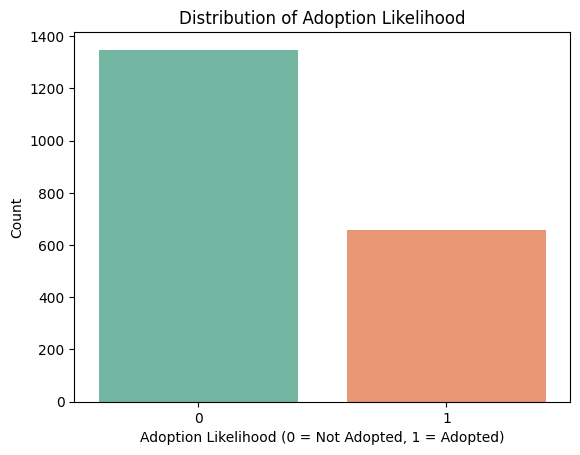

In [16]:
# Countplot for Adoption Likelihood with updated syntax
sns.countplot(data=pad, x="AdoptionLikelihood", hue="AdoptionLikelihood", palette="Set2", legend=False)

plt.xlabel("Adoption Likelihood (0 = Not Adopted, 1 = Adopted)")
plt.ylabel("Count")
plt.title("Distribution of Adoption Likelihood")
plt.show()

There's more '0's(Not be adopted) than '1's(adopted), which may lead to bias, the models would more likely to predict that the pet was not adopted. SMOTE will be used to reduce this bias.

### 4.2 Categorical Feature Distribution

#### 4.2.1 Pet Type Distribution (Bar Chart)

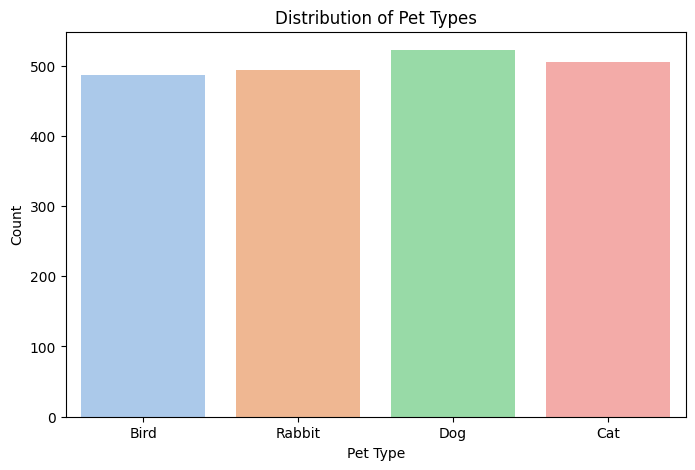

In [17]:
# Reload original dataset
pad = pd.read_csv('dataset/pet_adoption_data.csv')
# Bar chart for pet type distribution (Fixed Warning)
plt.figure(figsize=(8,5))
sns.countplot(x="PetType", data=pad, hue="PetType", palette="pastel", legend=False)

plt.xlabel("Pet Type")
plt.ylabel("Count")
plt.title("Distribution of Pet Types")
plt.show()

The category distribution of independent variables is more uniform, and the model will not be biased to a certain type of pets due to the imbalance of categories during training, which improves the fairness of prediction.

#### 4.2.2 Color Distribution (Pie Chart)

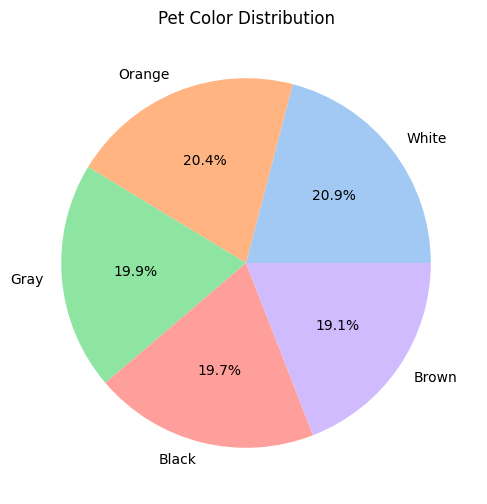

In [18]:
# Pie chart for pet color distribution
plt.figure(figsize=(6,6))
pad["Color"].value_counts().plot.pie(autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Pet Color Distribution")
plt.ylabel("")
plt.show()

The category distribution of independent variables is more uniform, and the model will not be biased to a certain type of pets due to the imbalance of categories during training, which improves the fairness of prediction.

#### 4.2.3 Breeds Distribution (Bar Chart）

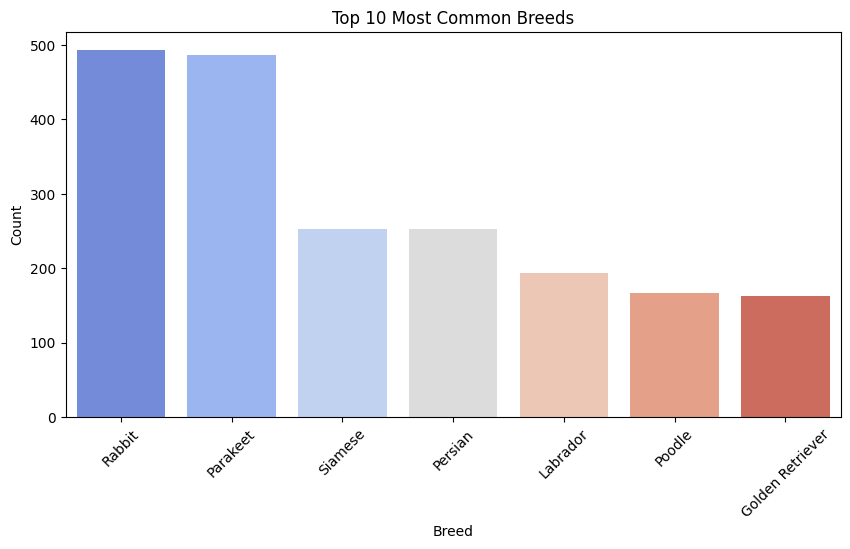

In [19]:
# Select top 10 most common breeds
top_breeds = pad["Breed"].value_counts().nlargest(10)

plt.figure(figsize=(10, 5))

# Updated barplot with hue
sns.barplot(x=top_breeds.index, y=top_breeds.values, hue=top_breeds.index, palette="coolwarm", legend=False)

plt.xticks(rotation=45)
plt.xlabel("Breed")
plt.ylabel("Count")
plt.title("Top 10 Most Common Breeds")
plt.show()

There's only 7 breeds, and each breed contains more than 100 piece of data, so there's no need to combine breeds to reduce dimension.

### 4.3 Numerical Feature Distribution

#### 4.3.1 Age Distribution (Histogram)

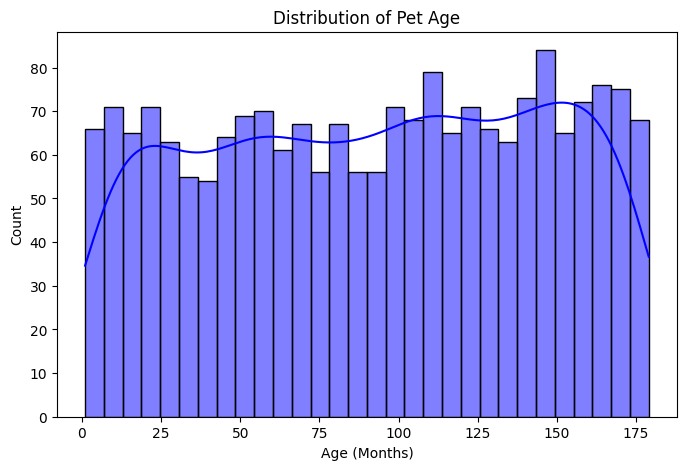

In [20]:
# Histogram for AgeMonths
plt.figure(figsize=(8,5))
sns.histplot(pad["AgeMonths"], bins=30, kde=True, color="blue")
plt.xlabel("Age (Months)")
plt.ylabel("Count")
plt.title("Distribution of Pet Age")
plt.show()

The age distribution is relatively average with no obvious trend.

#### 4.3.2 Weight Distribution（Boxplot)

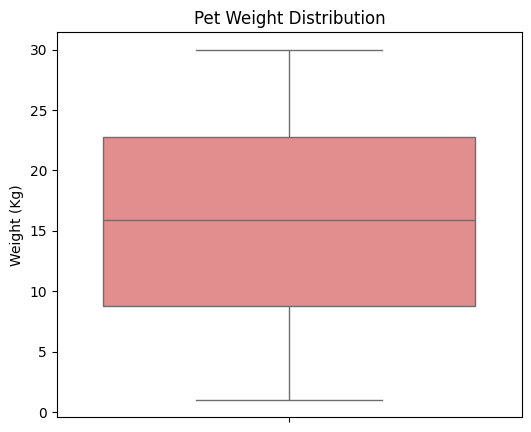

In [21]:
# Boxplot for WeightKg
plt.figure(figsize=(6,5))
sns.boxplot(y=pad["WeightKg"], color="lightcoral")
plt.ylabel("Weight (Kg)")
plt.title("Pet Weight Distribution")
plt.show()

The distribution is relatively average and there are no extreme values, which means that the previous data cleaning is effective.

#### 4.3.3 Distribution of time in shelter (Histogram)

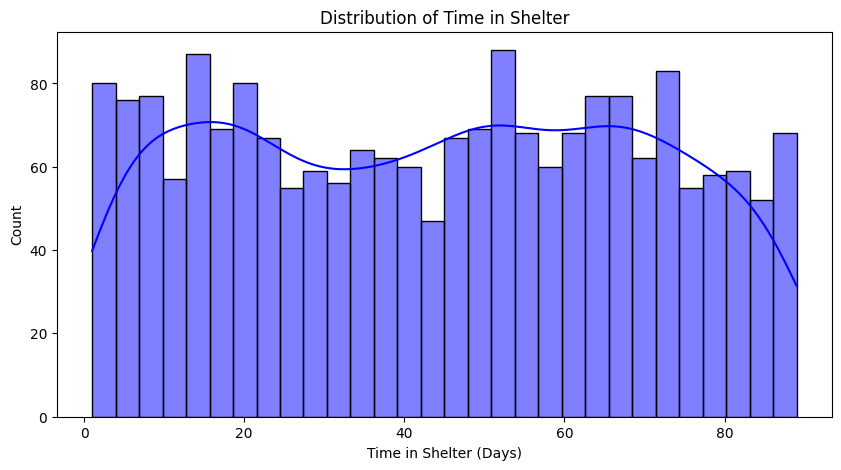

In [22]:
plt.figure(figsize=(10, 5))
sns.histplot(pad["TimeInShelterDays"], bins=30, kde=True, color="blue")

plt.xlabel("Time in Shelter (Days)")
plt.ylabel("Count")
plt.title("Distribution of Time in Shelter")
plt.show()

The age distribution is relatively average with no obvious trend.

### 4.4 Feature Correlation & Relationship

#### 4.4.1 Correlation Heatmap

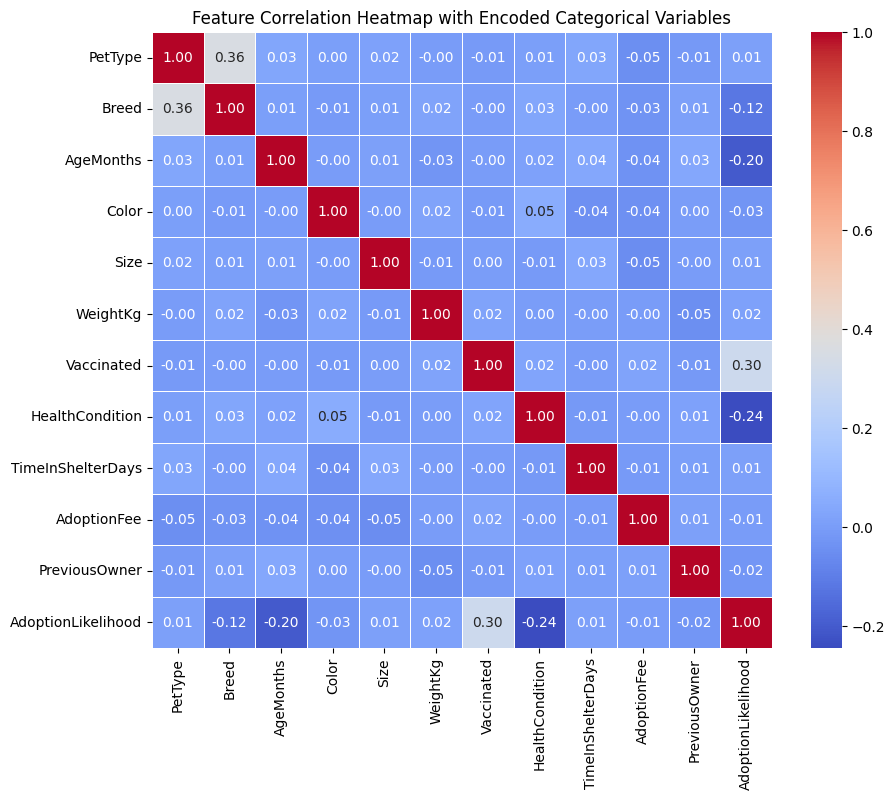

In [23]:
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding to categorical variables
categorical_columns = ["PetType", "Breed", "Color", "Size"]  # 选择类别变量
label_encoders = {}

for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    pad[col] = label_encoders[col].fit_transform(pad[col])

# Drop PetID column
numeric_pad = pad.drop(columns=["PetID"]).select_dtypes(include=["number"])

# Compute correlation matrix
corr = numeric_pad.corr()


# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap with Encoded Categorical Variables")
plt.show()

Health Condition and age has a negative relationship with Adoption, while Vaccinated has a positive relation with Adoption. The factors with no relationship (pet ID) will be deleted.

The columes with high relationships with adoption is further explored below.

#### 4.4.2 Vaccinated vs. Adoption Likelihood (Bar Chart)

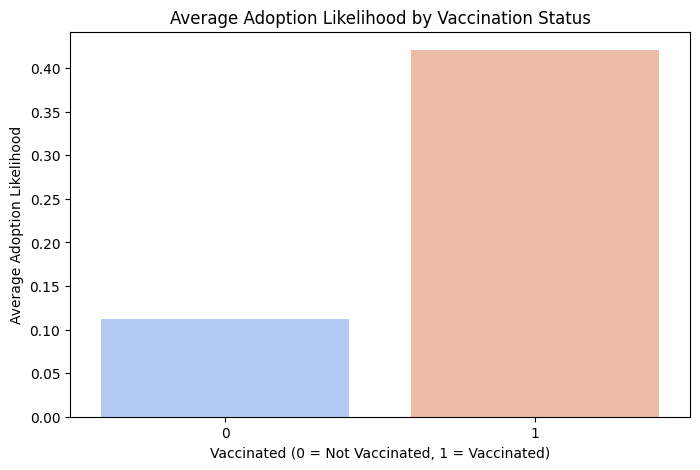

In [24]:
plt.figure(figsize=(8,5))

# Updated bar plot with errorbar and hue fix
sns.barplot(x="Vaccinated", y="AdoptionLikelihood", hue="Vaccinated", data=pad, errorbar=None, palette="coolwarm", legend=False)

plt.xlabel("Vaccinated (0 = Not Vaccinated, 1 = Vaccinated)")
plt.ylabel("Average Adoption Likelihood")
plt.title("Average Adoption Likelihood by Vaccination Status")
plt.show()

It looks like younger pets are more likely to be adopted.

#### 4.4.3 Health Condition vs. Adoption Likelihood

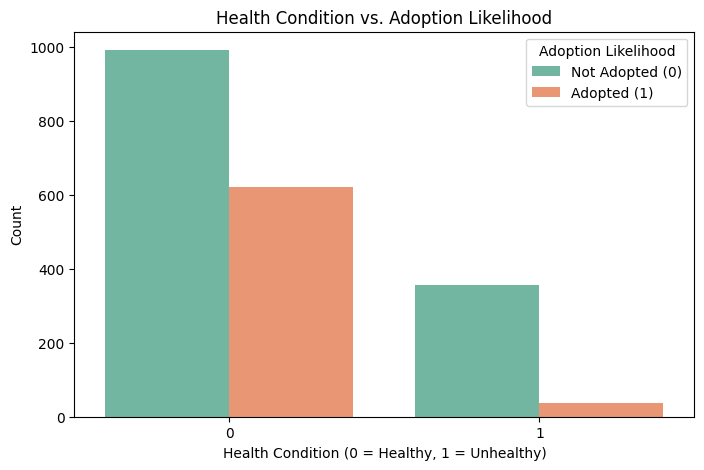

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

# Countplot for HealthCondition vs AdoptionLikelihood
sns.countplot(x="HealthCondition", hue="AdoptionLikelihood", data=pad, palette="Set2")

plt.xlabel("Health Condition (0 = Healthy, 1 = Unhealthy)")
plt.ylabel("Count")
plt.title("Health Condition vs. Adoption Likelihood")
plt.legend(title="Adoption Likelihood", labels=["Not Adopted (0)", "Adopted (1)"])
plt.show()

Healthy pets are more likely to be adopted.

#### 4.4.4 Time in Shelter vs. Adoption Likelihood (Violin Plot）

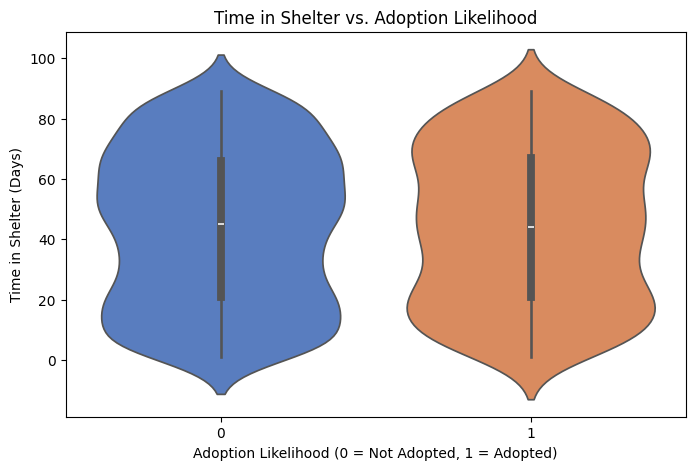

In [26]:
plt.figure(figsize=(8,5))

# Updated violin plot with hue
sns.violinplot(x="AdoptionLikelihood", y="TimeInShelterDays", hue="AdoptionLikelihood", data=pad, palette="muted", legend=False)

plt.xlabel("Adoption Likelihood (0 = Not Adopted, 1 = Adopted)")
plt.ylabel("Time in Shelter (Days)")
plt.title("Time in Shelter vs. Adoption Likelihood")
plt.show()

The time in the shelter is similarly distributed for both groups, suggesting that adoption likelihood is not strongly correlated with the duration of stay.

# 5.0 Create the Test Set

Splete the dataset into training set and testing set. The ratio of these sets refers to the Notebook *"97% Test Accuracy Pet Predict | EDA | XGB"*  by Umer Naeem.

In [27]:
# Define test set ratio (20% of the data for testing)
train_set, test_set = train_test_split(pad, test_size=0.2, random_state=17)

# Display dataset sizes
print("Training set size:", len(train_set))
print("Test set size:", len(test_set))

Training set size: 1605
Test set size: 402


In [28]:
# Define numerical features to normalize
numerical_features = ["AgeMonths", "WeightKg", "TimeInShelterDays", "AdoptionFee"]

# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to numerical features
scaled_numerical = scaler.fit_transform(pad[numerical_features])

# Convert scaled data into a DataFrame
df_scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical_features)

# Merge scaled data with the original dataset (removing original numerical columns)
pad = pd.concat([pad.drop(columns=numerical_features), df_scaled_numerical], axis=1)

# Save the updated dataset for later use
pad.to_csv("dataset/processed_dataset.csv", index=False)

# Display the first few rows of the processed dataset
# print(pad.head())
# Check for missing values in the training set
# print("Missing values in training set:\n", X_train.isnull().sum())

# Check for missing values in the test set
# print("\nMissing values in test set:\n", X_test.isnull().sum())

# 6.0 Applying Traditional Models

### 6.1 Logistic Regression

#### 6.1.1 Moduel Training

In [29]:
# Define Features and Target Variable
X_train = train_set.drop(columns=["AdoptionLikelihood"])  # Characteristics of the training set
y_train = train_set["AdoptionLikelihood"]  # The target variable of the training set

X_test = test_set.drop(columns=["AdoptionLikelihood"])  # Characteristics of the test set
y_test = test_set["AdoptionLikelihood"]  # The target variable of the test set

# Initialize and Train the Logistic Regression Model
log_model = LogisticRegression(max_iter=4500)  # Increase the number of iterations to ensure convergence
log_model.fit(X_train, y_train)

# Make Predictions
y_pred = log_model.predict(X_test)

#### 6.1.2 Evaluation

The first version performed well overall, with an accuracy of 0.74, but had a low recall. This means many adopted animals were misclassified as not adopted. After enhancing the data, adjusting class weights to handle imbalance, and normalizing the data, recall improved, but overall accuracy decreased. Increasing the number of iterations helped improve accuracy, reaching a local minimum at 4500 iterations. Further adjustments led to a plateau, so this version was kept. Random forest and XGBoost models were then tested for comparison.

In [30]:
# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Detailed Performance Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.7463
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81       256
           1       0.70      0.53      0.60       146

    accuracy                           0.75       402
   macro avg       0.73      0.70      0.71       402
weighted avg       0.74      0.75      0.74       402



### 6.2 Random Forest

#### 6.2.1 Moduel Training

In [31]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=500,   # Number of trees in the forest
    max_depth=None, # No depth limit (default behavior)
    random_state=17,    # Set seed for reproducibility
    class_weight="balanced"  # Handle class imbalance automatically
)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

#### 6.2.2 Evaluation

The random forest model seemed well-suited for this task, achieving 93% accuracy. To improve generalization, the number of trees was increased from 500 to 1000. This did not improve accuracy but did increase recall. Further increasing the number of trees did not bring better results. It was concluded that the minimum (most efficient point) was reached at 1000 trees, so adjustments were stopped.

Random Forest Model Accuracy: 0.9328
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       256
           1       0.98      0.84      0.90       146

    accuracy                           0.93       402
   macro avg       0.94      0.91      0.92       402
weighted avg       0.94      0.93      0.93       402



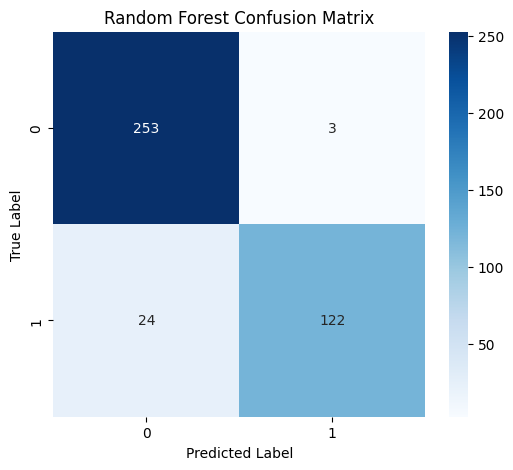

In [32]:
# Compute accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Model Accuracy: {rf_accuracy:.4f}")

# Print classification report
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Display confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.show()

### 6.3 XGBoost

#### 6.3.1 Moduel Training

In [33]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=1000, 
    max_depth=7, 
    learning_rate=0.01, 
    random_state=17, 
    eval_metric='logloss',
    verbosity=0  # Suppress training messages
)

xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

#### 6.3.2 Evaluation

XGBoost was the best-performing model. Without data augmentation, its recall for the adopted class was low, but it had the highest overall accuracy among all models. Testing a combination of high "n_estimators" and low "learning_rate" showed the best performance. Further increasing the number and depth of trees led to overfitting, so adjustments were stopped.

XGBoost Model Accuracy: 0.9577
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       256
           1       0.97      0.91      0.94       146

    accuracy                           0.96       402
   macro avg       0.96      0.95      0.95       402
weighted avg       0.96      0.96      0.96       402



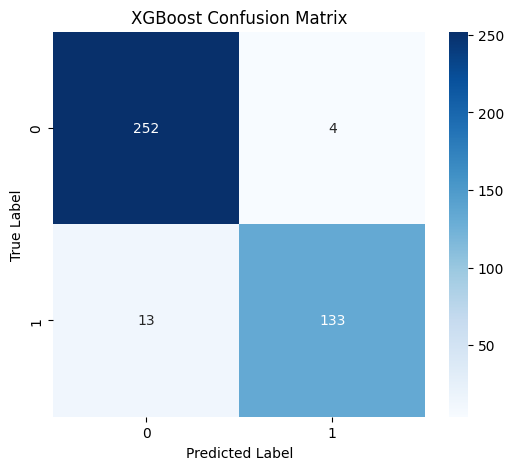

In [34]:
# Compute accuracy
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Model Accuracy: {xgb_accuracy:.4f}")

# Print classification report
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Display confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix")
plt.show()

### 6.4 Voting Classifier（Random Forest and XGBoost)

#### 6.4.1 Moduel Training

In [35]:
# Random Forest Classifier
random_forest = RandomForestClassifier(
    n_estimators=1000,  # Number of trees
    max_depth=None,  # Allow deep splits
    random_state=17,
    class_weight={0: 1, 1: 2}  # Handle class imbalance
)

# XGBoost Classifier with optimized hyperparameters
xgb = XGBClassifier(
    n_estimators=1500,
    max_depth=4,
    learning_rate=0.01,
    random_state=17,
    eval_metric='logloss',
    class_weight={0: 1, 1: 1.5},
    verbosity=0
)

# Create Voting Classifier with soft voting and weighted models
voting_clf = VotingClassifier(
    estimators=[
        ('Random Forest', random_forest),
        ('XGBoost', xgb),
    ],
    voting='soft',  # Use probability-based voting for better decision-making
    weights=[1, 2]  # Give equal weight to both models
)

# Train the Voting Classifier
voting_clf.fit(X_train, y_train)

# Make probability-based predictions on the test set
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]  # Extract probability for class 1

# Set a lower threshold for class 1
threshold = 0.4  # Lower threshold from 0.5 to 0.4 to improve recall
y_pred_voting = (y_pred_proba > threshold).astype(int)

# Display threshold impact
# print(f"Threshold: {threshold}")
# print(f"Predicted Positive Samples (1s): {sum(y_pred_voting)}")

#### 6.4.2 Evaluation

Combining the two models led to a lower overall accuracy in the Voting model due to the lower accuracy of the random forest. Both soft and hard voting were tested, and soft voting performed better than hard voting, as soft voting allowed XGBoost to contribute more meaningfully to the final prediction. Compared to using only random forest or XGBoost, the Voting model was more complex and prone to overfitting. This made it harder to fine-tune and resulted in worse performance than XGBoost.

Voting Classifier Model Accuracy: 0.9428
Voting Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       256
           1       0.94      0.90      0.92       146

    accuracy                           0.94       402
   macro avg       0.94      0.93      0.94       402
weighted avg       0.94      0.94      0.94       402



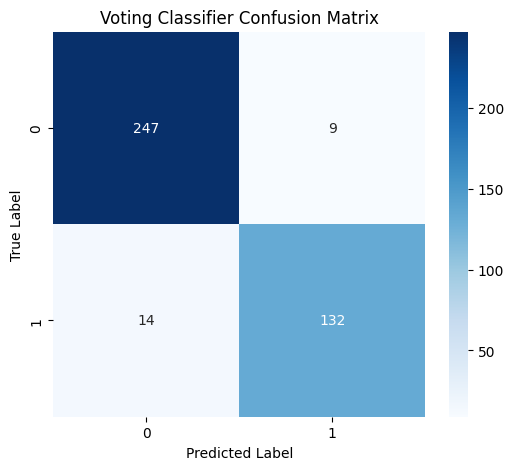

In [36]:
# Compute accuracy
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Model Accuracy: {voting_accuracy:.4f}")

# Print classification report
print("Voting Classifier Classification Report:\n", classification_report(y_test, y_pred_voting))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Voting Classifier Confusion Matrix")
plt.show()

### 6.5 Stacking approach using XGBoost as the meta-model

#### 6.5.1 Moduel Training

In [37]:
# Train Base Model (Random Forest)
random_forest = RandomForestClassifier(
    n_estimators=1000,  # Number of trees
    max_depth=4,  # Maximum depth of each tree
    min_samples_split=4,  # Prevent overfitting
    random_state=17,
    class_weight={0: 1, 1: 1.5} 
)

# Fix the variable name
random_forest.fit(X_train, y_train)  # Change x_train_rf → X_train, y_train_rf → y_train

# Step 2: Generate predictions from Random Forest
rf_train_preds = random_forest.predict_proba(X_train)[:, 1]  # Use probability for better learning
rf_test_preds = random_forest.predict_proba(X_test)[:, 1]  # Predict for test set

# Step 3: Stack Random Forest predictions with original features
X_train_meta_stacked = np.column_stack((X_train, rf_train_preds))
X_test_stacked = np.column_stack((X_test, rf_test_preds))

# smote = SMOTE(sampling_strategy=0.5, random_state=17)  # 使两类数据数量相等
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_meta_stacked, y_train)
X_train_resampled, y_train_resampled = X_train_meta_stacked, y_train

# Step 4: Train Meta Model (XGBoost)
xgb_meta = XGBClassifier(
    n_estimators=1500,
    max_depth=4,
    learning_rate=0.1,
    random_state=17,
   scale_pos_weight=3,
    eval_metric="logloss"
)

xgb_meta.fit(X_train_resampled, y_train_resampled)  # Make sure you use the correct training labels
# Step 5: Make Predictions
y_pred_xgb = xgb_meta.predict(X_test_stacked)

#### 6.5.2 Evaluation

The Stacking method was used, incorporating the predicted probabilities from the Random Forest model as new features to train XGBoost as the meta-model, leveraging the strengths of both models. However, due to the complexity of XGBoost, parameter tuning was challenging, and the model was prone to overfitting. After multiple adjustments, the best accuracy of 93.03% was achieved. Increasing the number of trees easily led to XGBoost overfitting, while increasing the depth of the Random Forest model reduced recall for the minority class. In this task, the recall for the "adopted" category decreased, indicating that the model tended to predict pets as "not adopted."

Stacked Model Accuracy: 0.9303
Stacked Model Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       256
           1       0.92      0.88      0.90       146

    accuracy                           0.93       402
   macro avg       0.93      0.92      0.92       402
weighted avg       0.93      0.93      0.93       402



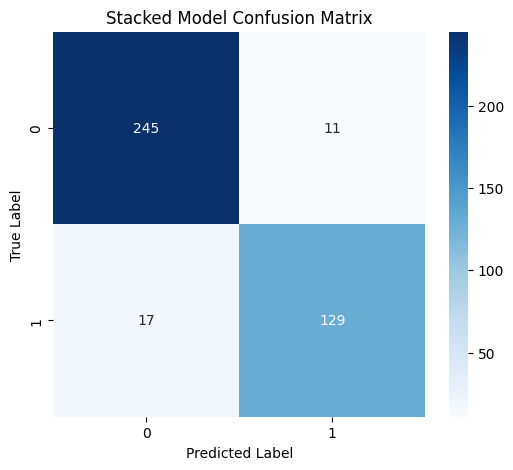

In [38]:
# Step 6: Compute accuracy
stacked_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Stacked Model Accuracy: {stacked_accuracy:.4f}")

# Step 7: Print Classification Report
print("Stacked Model Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Step 8: Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Stacked Model Confusion Matrix")
plt.show()

# 7.0 Applying Feedforward Neural Network (FNN)

### 7.1 Data Preprocessing

Min-Max normalization is used as it works better on data that is not normally distributed.

In [39]:

# Set global seed to ensure reproducibility
SEED = 17
np.random.seed(SEED)  # Fix NumPy randomness
random.seed(SEED)  # Fix Python's built-in random module
tf.random.set_seed(SEED)  # Fix TensorFlow randomness
os.environ['PYTHONHASHSEED'] = str(SEED)  # Ensure consistent hash seed

# Load dataset
df = pd.read_csv("dataset/processed_dataset.csv")

# Separate features and labels
X = df.drop(columns=['AdoptionLikelihood'])  # Features
y = df['AdoptionLikelihood']  # Target variable

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)  # Ensure class distribution is maintained

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy=1.0, random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalize numerical features
scaler = MinMaxScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

### 7.2 Define FNN Model

In [40]:
# model layout
model = Sequential([
    Dense(512, activation='relu', kernel_initializer=GlorotUniform(seed=SEED), input_shape=(X_train_resampled.shape[1],)),
    Dense(256, activation='relu', kernel_initializer=GlorotUniform(seed=SEED)),
    Dense(128, activation='relu', kernel_initializer=GlorotUniform(seed=SEED)),
    Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform(seed=SEED))  # Binary classification
])

# Build the Feedforward Neural Network (FNN)
model = Sequential([
    Dense(512, activation='relu', kernel_initializer=GlorotUniform(seed=SEED), input_shape=(X_train_resampled.shape[1],), kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, activation='relu', kernel_initializer=GlorotUniform(seed=SEED), kernel_regularizer=l2(0.003)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu', kernel_initializer=GlorotUniform(seed=SEED), kernel_regularizer=l2(0.003)),
    
    Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform(seed=SEED))  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower learning rate for stable training
    loss='binary_crossentropy',  # Suitable for binary classification
    metrics=['accuracy']
)


/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-04 18:10:40.675094: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### 7.3 Model Training

In [41]:
# Define class weights (higher weight for minority class)
class_weights = {0: 1.0, 1: 2.0}

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True
)

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Stop if val_loss does not improve for 10 epochs
    min_delta=0.001,
    restore_best_weights=True
)
# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=70,
    batch_size=64,
    class_weight=class_weights,
    shuffle=False,  # Ensure consistency in training process
    verbose=1
)

# Save the trained model
model.save("fnn_model.keras")



Epoch 1/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5965 - loss: 2.6583 - val_accuracy: 0.4303 - val_loss: 2.2221
Epoch 2/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5773 - loss: 2.4747 - val_accuracy: 0.3284 - val_loss: 2.2062
Epoch 3/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5609 - loss: 2.4029 - val_accuracy: 0.3284 - val_loss: 2.1974
Epoch 4/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5658 - loss: 2.3006 - val_accuracy: 0.3284 - val_loss: 2.1912
Epoch 5/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5961 - loss: 2.2082 - val_accuracy: 0.3284 - val_loss: 2.2209
Epoch 6/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6272 - loss: 2.1186 - val_accuracy: 0.3284 - val_loss: 2.1871
Epoch 7/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6569 - loss: 2.0331 - val_accuracy: 0.3259 - val_loss: 2.1619
Epoch 8/70
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6769 - loss: 1.9496 - val_accuracy: 0.3532 - v

### 7.4 Evaluation

Compared to traditional models, the performance of FNN was suboptimal, with an initial accuracy of only around 85% before tuning. Additionally, the model exhibited significant overfitting and bias, specifically manifesting as much worse performance on the test set compared to the training set, along with a notably low recall for the "adopted" class.
To address these issues, several adjustments were made. First, the dropout rate was increased from 0.3 to 0.5 to reduce overfitting. Additionally, the number of training epochs was reduced, and early stopping was introduced to save computational resources. However, this led to underfitting.
To counteract this, the strategy was adjusted by increasing the number of training epochs and applying SMOTE and class weight techniques to enhance the model’s sensitivity to the "adopted" class, which had fewer data points. After multiple rounds of tuning, the test accuracy improved to 89%, while the gap between test accuracy and training accuracy (92%) was reduced. This result appeared to be a local minimum. Due to time constraints, further tuning was halted, and in the next section, Keras Tuner will be used to continue optimization in search of a global minimum.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
FNN Model Accuracy: 0.8980
FNN Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       270
           1       0.85      0.83      0.84       132

    accuracy                           0.90       402
   macro avg       0.89      0.88      0.88       402
weighted avg       0.90      0.90      0.90       402



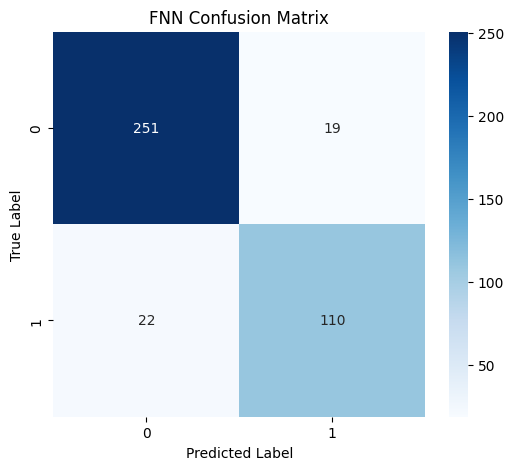

In [42]:
from tensorflow.keras.models import load_model


# Load the trained model
model = load_model("fnn_model.keras")

# Make predictions on the test set
y_pred_proba = model.predict(X_test)  # Get probability output
y_pred_fnn = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary classes

# Compute accuracy
fnn_accuracy = accuracy_score(y_test, y_pred_fnn)
print(f"FNN Model Accuracy: {fnn_accuracy:.4f}")

# Print classification report
print("FNN Classification Report:\n", classification_report(y_test, y_pred_fnn))

# Display confusion matrix
plt.figure(figsize=(6, 5))
conf_matrix = confusion_matrix(y_test, y_pred_fnn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("FNN Confusion Matrix")
plt.show()

# 8.0 Hyperparameter Tuning of FNN

### 8.1 Setting Random Seed for Reproducibility

In [43]:
SEED = 17
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

### 8.2 Import Keras Tuner and Define Hyperparameter Search Space

In [44]:
# Define the function to build the model with hyperparameters
def build_model(hp):
    model = Sequential()

    # Define the number of neurons in the first layer
    model.add(Dense(
        units=hp.Int('units_1', min_value=256, max_value=512, step=128),  
        activation='relu',
        kernel_initializer=GlorotUniform(seed=SEED),
        input_shape=(X_train_resampled.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.1)))  

    # Define the number of neurons in the second layer
    model.add(Dense(
        units=hp.Int('units_2', min_value=256, max_value=512, step=128),
        activation='relu',
        kernel_initializer=GlorotUniform(seed=SEED),
        kernel_regularizer=l2(hp.Choice('l2_2', values=[0.001, 0.002, 0.005]))  
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.6, step=0.1)))

    # Define the number of neurons in the third layer
    model.add(Dense(
        units=hp.Int('units_3', min_value=64, max_value=256, step=64),
        activation='relu',
        kernel_initializer=GlorotUniform(seed=SEED),
        kernel_regularizer=l2(hp.Choice('l2_3', values=[0.001, 0.005, 0.01]))  
    ))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.6, step=0.1)))  

    # Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform(seed=SEED)))

    # Compile model
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[0.0001, 0.0002, 0.003])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


### 8.4 Using Keras Tuner for Hyperparameter Optimization

In [45]:
# Initialize the tuner (Random Search)
tuner = kt.RandomSearch(
    build_model,  
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter sets to try
    executions_per_trial=1,  # Number of times each model is trained for averaging
    directory='keras_tuner_results',
    project_name='fnn_hyperparameter_tuning',
    overwrite=True
)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Search for the best hyperparameters
tuner.search(X_train_resampled, y_train_resampled, epochs=30, validation_split=0.2, callbacks=[early_stopping])

# Get the best hyperparameter combination
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 00m 32s]
val_accuracy: 0.9513888955116272

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 04m 38s


### 8.5 Model Training

In [46]:
# Compute class weights manually
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Build the final model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the best model
history = best_model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_test, y_test),
    epochs=30, batch_size=64, 
    class_weight=class_weights_dict,  # <- Corrected class_weight format
    shuffle=False,  
    callbacks=[early_stopping],
    verbose=1
)

# Save the optimized model
best_model.save("fnn_model_optimized.keras")


Epoch 1/30


/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5774 - loss: 1.5420 - val_accuracy: 0.5970 - val_loss: 1.3063
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6331 - loss: 1.3750 - val_accuracy: 0.3433 - val_loss: 1.3342
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6802 - loss: 1.3042 - val_accuracy: 0.3284 - val_loss: 1.3577
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6713 - loss: 1.2942 - val_accuracy: 0.3284 - val_loss: 1.3807
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6834 - loss: 1.2539 - val_accuracy: 0.3284 - val_loss: 1.4021
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6775 - loss: 1.2703 - val_accuracy: 0.3284 - val_loss: 1.4047
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6940 - loss: 1.2348 - val_accuracy: 0.3358 - val_loss: 1.3909
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7152 - loss: 1.2196 - val_accuracy: 0.3657 - val_loss: 1.

### 8.6 Model Evaluation

The fine-tuning results were unsatisfactory, as the overfitting issue and the low recall for the "adopted" class remained unresolved. The initial model exhibited significant instability, with accuracy fluctuating drastically between 85% and 55%. To stabilize the model and facilitate further adjustments, a random seed was set to ensure consistency in training and test set splits.  
To mitigate overfitting, early stopping was introduced, and the number of training epochs was reduced while also narrowing the dropout range and search space. These adjustments improved model stability; however, the global minimum was still not found.  
The next optimization strategy involves replacing random search with **Grid Search** to enhance hyperparameter tuning efficiency. Additionally, dropout and L2 regularization strength will be reduced to improve the model’s generalization ability. Furthermore, the learning rate will be increased to accelerate convergence and reduce the risk of getting stuck in a local minimum.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
Optimized FNN Model Accuracy: 0.8582
Optimized FNN Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       270
           1       0.83      0.72      0.77       132

    accuracy                           0.86       402
   macro avg       0.85      0.82      0.83       402
weighted avg       0.86      0.86      0.86       402



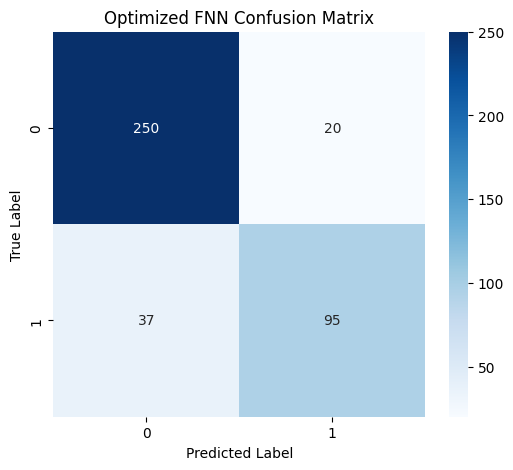

In [47]:
# Load the trained optimized model
optimized_model = load_model("fnn_model_optimized.keras")

# Make predictions on the test set
y_pred_proba = optimized_model.predict(X_test)  
y_pred_fnn = (y_pred_proba > 0.5).astype(int)  

# Compute accuracy
fnn_accuracy = accuracy_score(y_test, y_pred_fnn)
print(f"Optimized FNN Model Accuracy: {fnn_accuracy:.4f}")

# Print classification report
print("Optimized FNN Classification Report:\n", classification_report(y_test, y_pred_fnn))

# Display confusion matrix
plt.figure(figsize=(6, 5))
conf_matrix = confusion_matrix(y_test, y_pred_fnn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Optimized FNN Confusion Matrix")
plt.show()